In [1]:
from nanocontrol import nanocontrol, controller
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pandas as pd
import json
import os
import random
import serial

In [2]:
controller = controller()
nc = controller.ncs['1']

def chill(pos, seconds):
    nc.setFinePosVoltage('A', 0)
    nc.setFinePosVoltage('B', 0)
    nc.setFinePos16Bit('C', pos)
    nc.setFinePosVoltage('D', 0)
    time.sleep(seconds)
def reset(pos, seconds):
    nc.setFinePos16Bit('A', 0)
    nc.setFinePos16Bit('B', 0)
    nc.setFinePos16Bit('C', pos)
    nc.setFinePos16Bit('D', 0)
    time.sleep(seconds)
    nc.resetCoarseCounter()
    nc.resetCounter()

KeyError: '1'

In [ ]:
import multimeter
multi = serial.Serial('COM4',
                baudrate=2400,
                parity=serial.PARITY_NONE,
                stopbits=serial.STOPBITS_ONE,
                bytesize=serial.EIGHTBITS,
                timeout=1)
def read_multimeter():
    if multi.is_open:
        data = multi.read(14)
        temp = multimeter.parseBlockAndCalcTemp(data)
        return temp
    else:
        print("Error: Can't read multimeter")
        return None
read_multimeter()

22.5

In [ ]:
read_multimeter()

22.5

#### Random Walks

In [7]:
def generate_random_walks(n_walks, steps_per_walk, max_step_size=1024, lower=-np.power(2,15), upper=np.power(2,15), pause_interval=2147483647, pause_duration=0):
    walks = []
    for _ in range(n_walks):
        start_position = random.randint(lower, upper)
        end_position = random.randint(lower, upper)
        
        walk = [start_position]

        prev_step = 0
        #print(pause_interval)
        for i in range(steps_per_walk):
            if (i+1) % pause_interval == 0:
                walk += [walk[-1]]*pause_duration
            
            current_position = walk[-1]
            # Calculate the remaining distance to the target
            distance = end_position - current_position

            #if abs(distance) < max_step_size/4:
            #    break
            
            step = random.randint(-max_step_size, max_step_size)

            if random.random() < 0.8:
                if np.sign(step) != np.sign(prev_step):
                    step = -step

            if current_position + step < lower or current_position + step > upper:
                step = -step

            # there shold be a 0.4 probability that the movement will be in the opposite direction
            # if i > steps_per_walk*0.7 and random.random() < 0.55:
            #     if np.sign(step) != np.sign(distance):
            #         step = -step

            # Append the new position
            walk.append(walk[-1] + step)
            prev_step = step

        walk = np.convolve(walk, np.ones(128)/128, mode='valid').tolist()

        # now use a logaritmic function to approach the final position in the next 100 steps
        # log_fraction = 0.2
        # log_steps = int(len(walk)*log_fraction)
        # for i in range(log_steps):
        #     walk.append(int((end_position - walk[-1]) * (1 - np.exp(-i/log_steps)) + walk[-1]))
        #     if abs(end_position - walk[-1]) < np.abs(step)/16:
        #         break
        
        walks.append(np.array(walk).astype(int))
    
    return walks

#### Record 5h of random walk

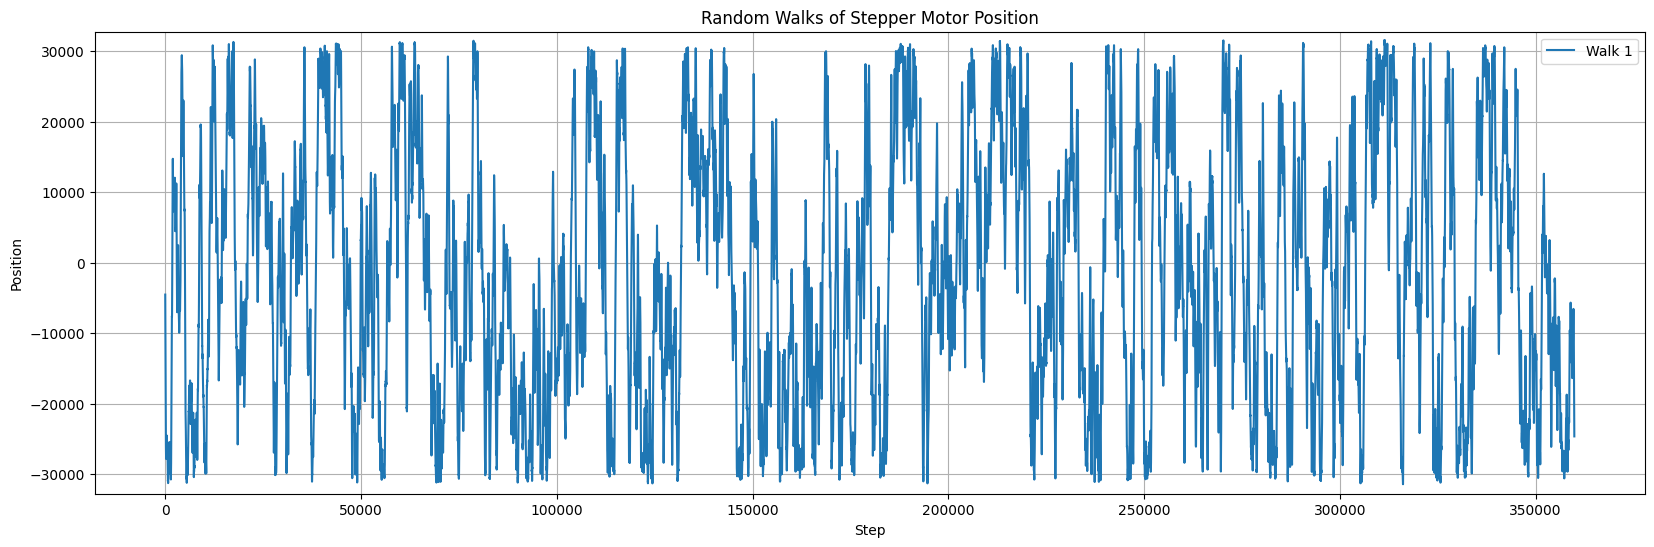

In [8]:
# Generate 3 random walks with at least 360 steps each
n_walks = 1  # number of random walks
steps_per_second = 10

walk_duration_minutes = 600
pause_interval_minutes = 600
pause_duration_minutes = 0


steps_per_walk = steps_per_second * 60 * walk_duration_minutes
pause_interval = steps_per_second * 60 * pause_interval_minutes
pause_duration = steps_per_second * 60 * pause_duration_minutes
walks = generate_random_walks(n_walks, steps_per_walk, max_step_size=512, pause_interval=pause_interval, pause_duration=pause_duration)

plt.figure(figsize=(20, 6))
for i in range(n_walks):
    #plt.plot(walks[i], label=f'Walk {i+1}')
    plt.plot(range(len(walks[i])), walks[i], label=f'Walk {i+1}')
plt.title('Random Walks of Stepper Motor Position')
plt.xlabel('Step')
plt.ylim(-np.power(2,15), np.power(2,15))
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
df = pd.DataFrame(columns=['finestep', 'time', 'c_0', 'c_1', 'c_2', 'c_3', 'c_4', 'temp'])
for i in range(len(walks)):
    df['finestep'] = walks[i]
    temp = read_multimeter()
    reset(0, 120)
    start = time.time()
    for index, row in tqdm(df.iterrows(), total=len(df)):
        nc.setFinePos16Bit('C',int(row['finestep']))
        row['time'] = time.time()
        row['c_0'] = nc.readCounter()['C']
        row['c_1'] = nc.readCounter()['C']
        row['c_2'] = nc.readCounter()['C']
        row['c_3'] = nc.readCounter()['C']
        row['c_4'] = nc.readCounter()['C']
        if index % 10 == 0:
            try:
                temp = read_multimeter()
            except:
                temp = -1
        row['temp'] = temp
        df.iloc[index] = row
        if index % 18000 == 0:
            df.to_csv(f'../dat/creep/random_walk_{walk_duration_minutes}min_pause{pause_duration_minutes}at{pause_interval_minutes}min_{i}_part.csv', index=False)
    df['time'] = df['time'] - start
    df['c_mean'] = df[['c_0', 'c_1', 'c_2', 'c_3', 'c_4']].astype(int).mean(axis=1)

    df.to_csv(f'../dat/creep/random_walk_{walk_duration_minutes}min_pause{pause_duration_minutes}at{pause_interval_minutes}min_{i}.csv', index=False)
    os.remove(f'../dat/creep/random_walk_{walk_duration_minutes}min_pause{pause_duration_minutes}at{pause_interval_minutes}min_{i}_part.csv')

100%|██████████| 287874/287874 [9:24:30<00:00,  8.50it/s]   


#### Record 15 min input, 30 min creep

18000


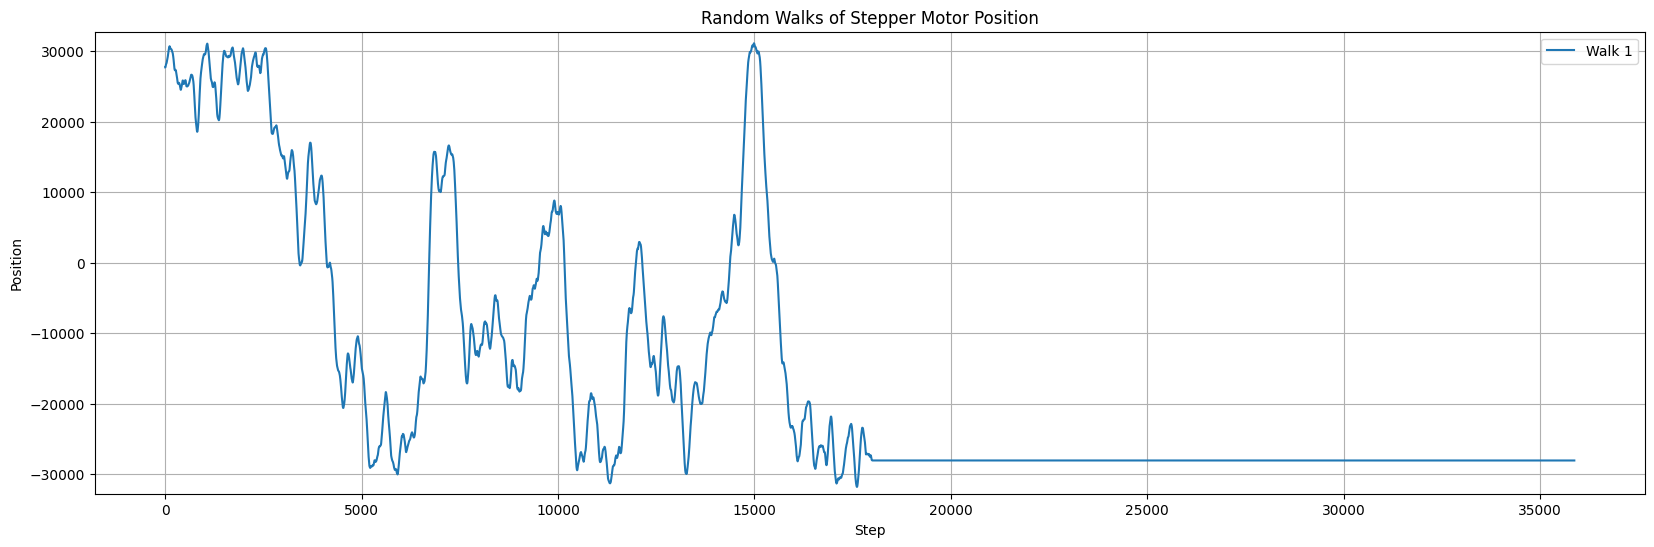

In [5]:
# Generate 3 random walks with at least 360 steps each
n_walks = 1  # number of random walks
steps_per_second = 10

walk_duration_minutes = 30
pause_interval_minutes = 30
pause_duration_minutes = 30


steps_per_walk = steps_per_second * 60 * walk_duration_minutes
pause_interval = steps_per_second * 60 * pause_interval_minutes
pause_duration = steps_per_second * 60 * pause_duration_minutes
walks = generate_random_walks(n_walks, steps_per_walk, max_step_size=512, pause_interval=pause_interval, pause_duration=pause_duration)

plt.figure(figsize=(20, 6))
for i in range(n_walks):
    #plt.plot(walks[i], label=f'Walk {i+1}')
    plt.plot(range(len(walks[i])), walks[i], label=f'Walk {i+1}')
plt.title('Random Walks of Stepper Motor Position')
plt.xlabel('Step')
plt.ylim(-np.power(2,15), np.power(2,15))
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()

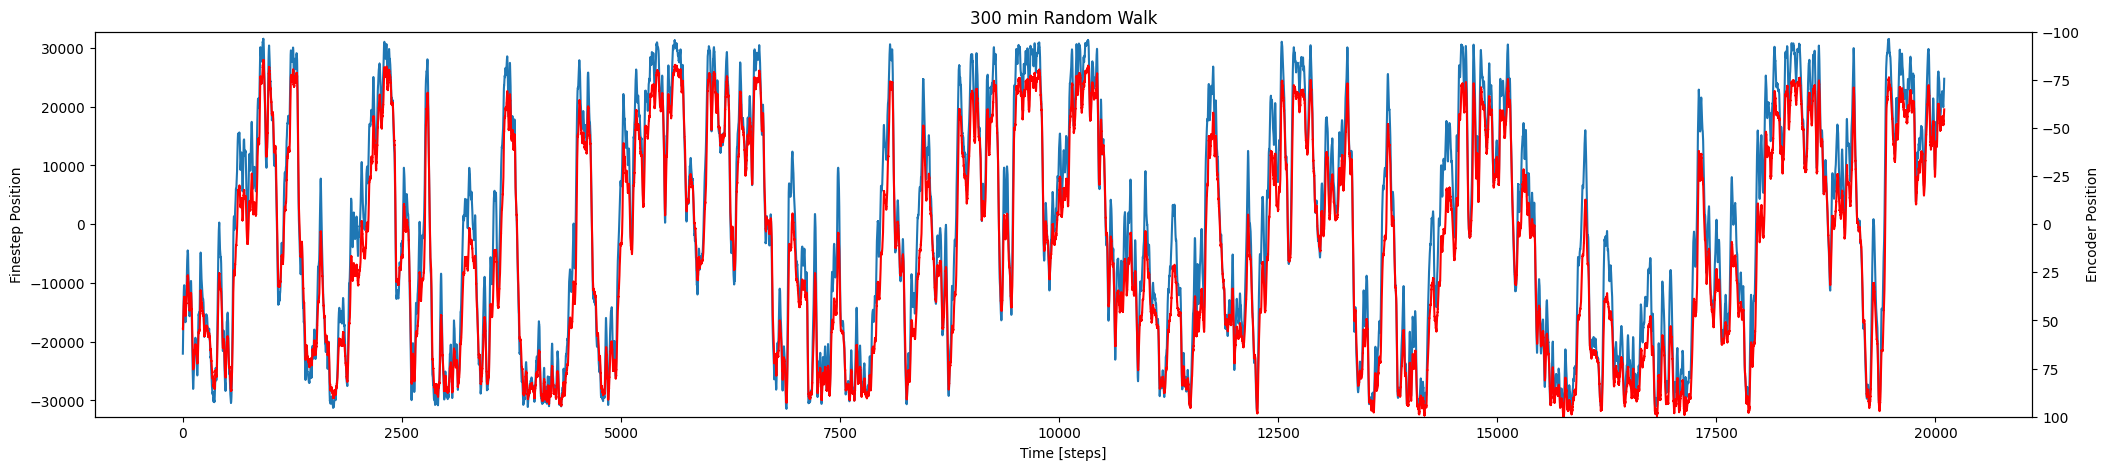

In [34]:
df = pd.read_csv(r'..\dat\walks\random_walk_300min.csv')
# set all temps above 40 to nan
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df['time'], df['finestep'], label='finestep')
ax.set_ylim(-np.power(2,15), np.power(2,15))
# second y-axis
ax2 = ax.twinx()
ax2.set_ylim(100, -100)

plt.title('300 min Random Walk')
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Finestep Position')
ax2.set_ylabel('Encoder Position')
ax2.plot(df['time'], df['c_mean'].rolling(8).mean(), label='counter mean', color='red')
#ax.set_xlim(18000, 35000)

(1000.0, 4000.0)

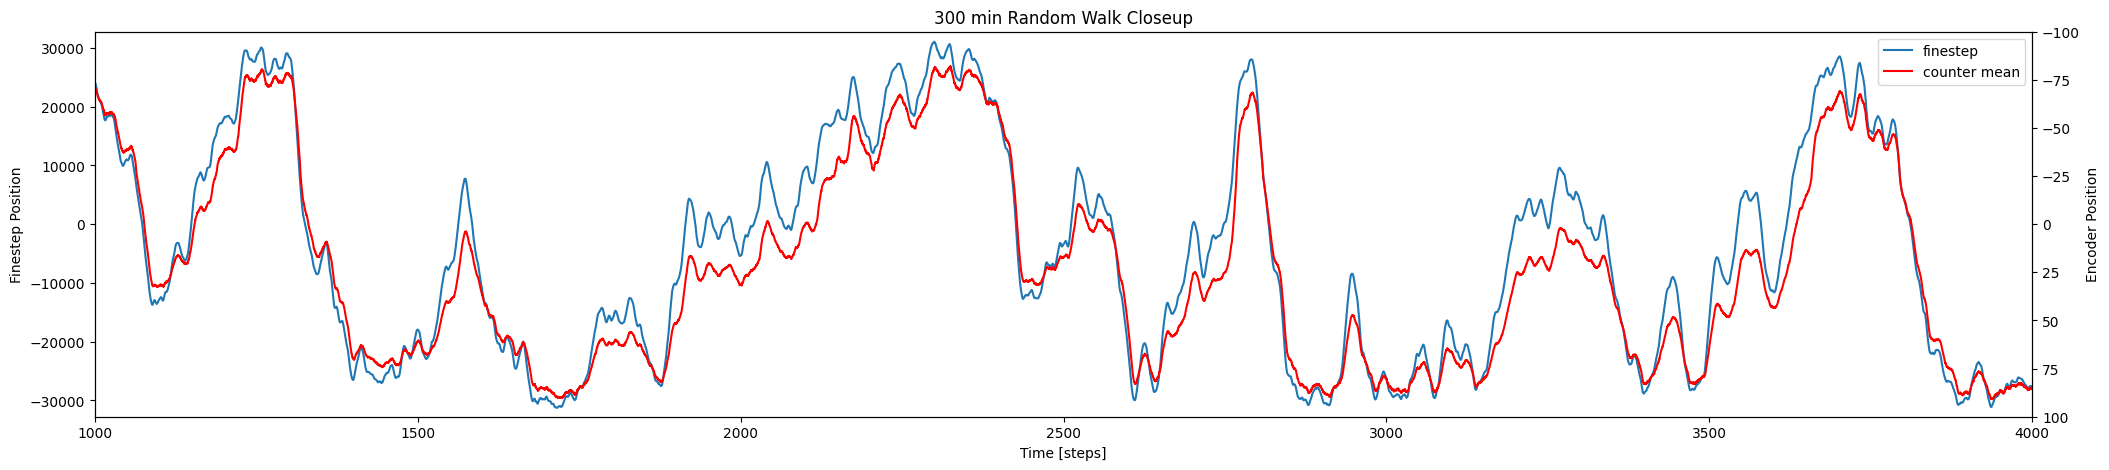

In [35]:
# set all temps above 40 to nan
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df['time'], df['finestep'], label='finestep')
ax.set_ylim(-np.power(2,15), np.power(2,15))
# second y-axis
ax2 = ax.twinx()
ax2.set_ylim(100, -100)
ax2.plot(df['time'], df['c_mean'].rolling(8).mean(), label='counter mean', color='red')

plt.title('300 min Random Walk Closeup')
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Finestep Position')
ax2.set_ylabel('Encoder Position')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
ax.set_xlim(1000, 4000)

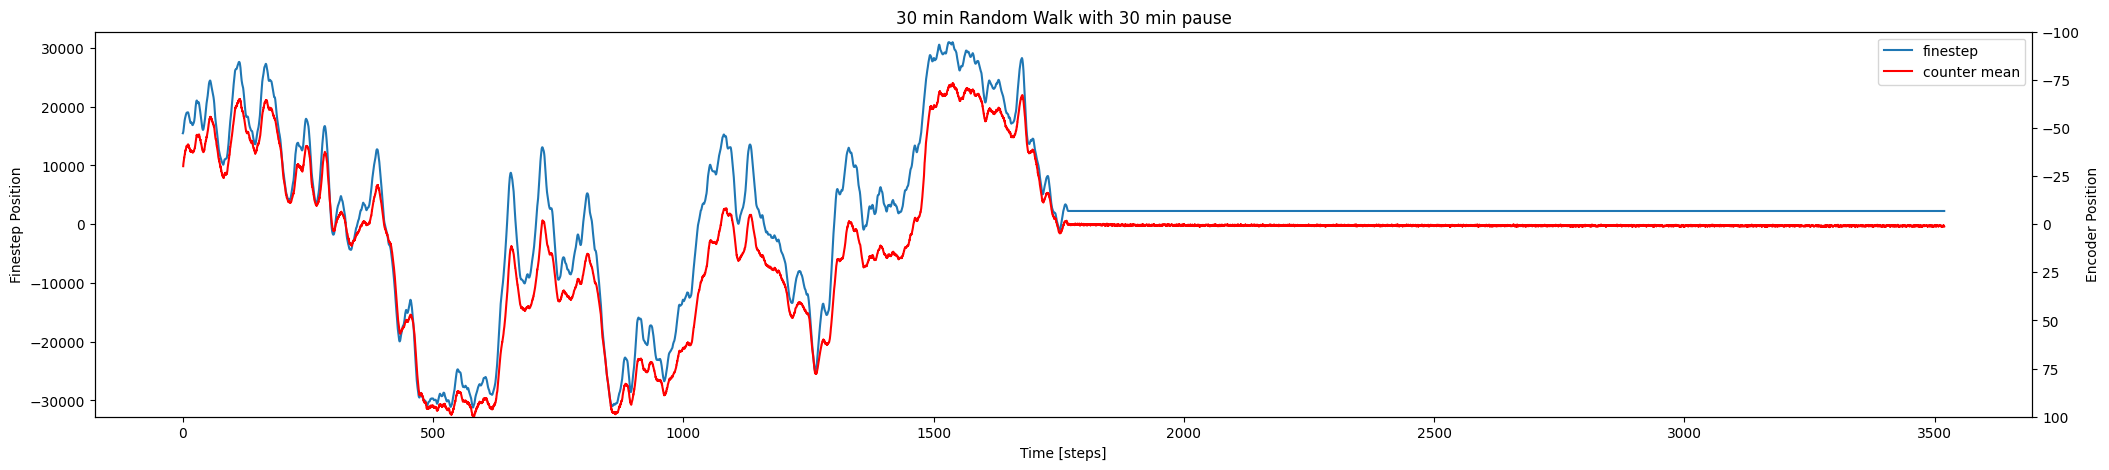

In [36]:
df = pd.read_csv(r'..\dat\creep\random_walk_30min_pause30at30min_0.csv')
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df['time'], df['finestep'], label='finestep')
ax.set_ylim(-np.power(2,15), np.power(2,15))
# second y-axis
ax2 = ax.twinx()
ax2.set_ylim(100, -100)
ax2.plot(df['time'], df['c_mean'].rolling(8).mean(), label='counter mean', color='red')

plt.title('30 min Random Walk with 30 min pause')
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Finestep Position')
ax2.set_ylabel('Encoder Position')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
#ax.set_xlim(18000, 35000)

(1500.0, 3000.0)

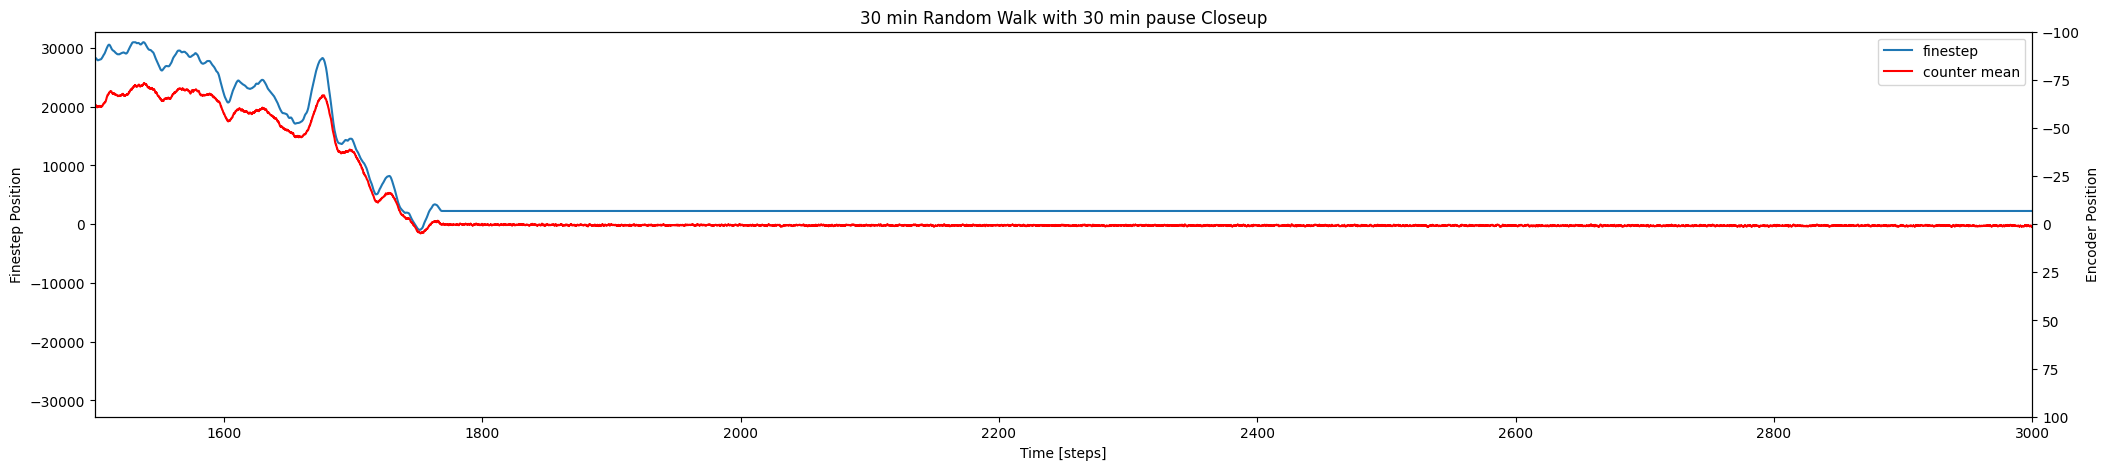

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df['time'], df['finestep'], label='finestep')
ax.set_ylim(-np.power(2,15), np.power(2,15))
# second y-axis
ax2 = ax.twinx()
ax2.set_ylim(100, -100)
ax2.plot(df['time'], df['c_mean'].rolling(8).mean(), label='counter mean', color='red')


plt.title('30 min Random Walk with 30 min pause Closeup')
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Finestep Position')
ax2.set_ylabel('Encoder Position')

# merge the legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)

ax.set_xlim(1500, 3000)